# Solving Michalewicz function using PSO


The Michalewicz function has $d!$ local minima, and it is multimodal. 

Formula: $f(X)=-\sum_{j=1}^{n}\sin\left(x_j\right)\left[\sin\left(\displaystyle\frac{jx^2_j}{\pi}\right)\right]^{2m} \ \ , \ \ \ m=10$

Dimensions: d

Input Domain: The function is usually evaluated on $x_i ∈ [0, \pi]$, for all $i = 1, …, d$.

Global Minimum: 

* at $d=2$: $f(x^*)=-1.8013$ at $x^*=(2.20,1.57)$
* at $d=5$: $f(x^*)=-4.687658$
* at $d=10$: $f(x^*)=-9.66015$

### Define the problem

In [13]:
import numpy as np
import math
import matplotlib.pyplot as plt

def michalewicz_function(position):
    m=10
    n = len(position)
    return -sum([math.sin(x) * (math.sin((i+1) * x ** 2 / math.pi)) ** (2*m) for i, x in enumerate(position)])

#### Visualize the problem landscape

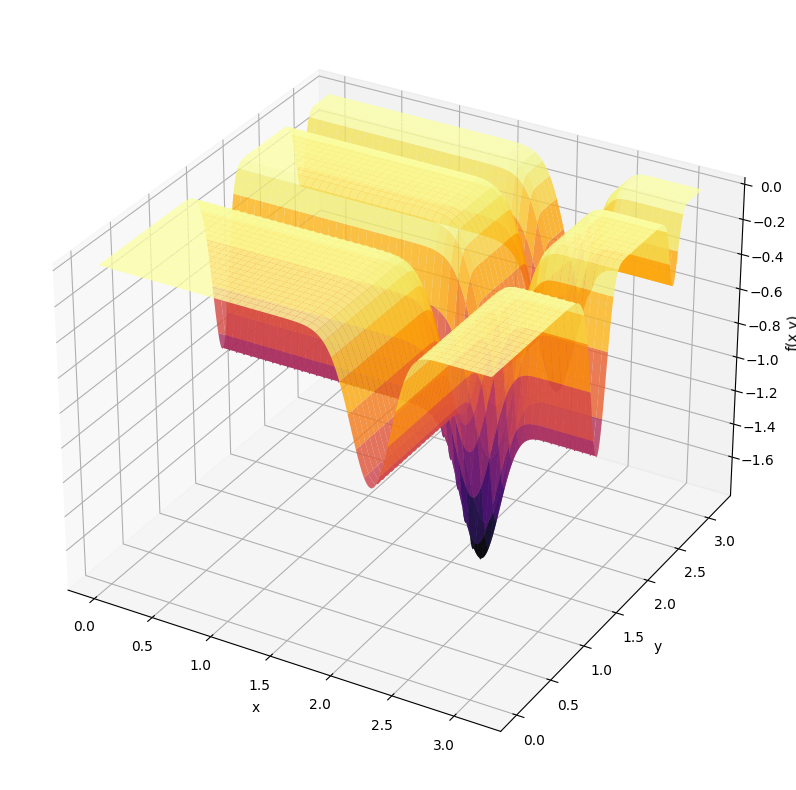

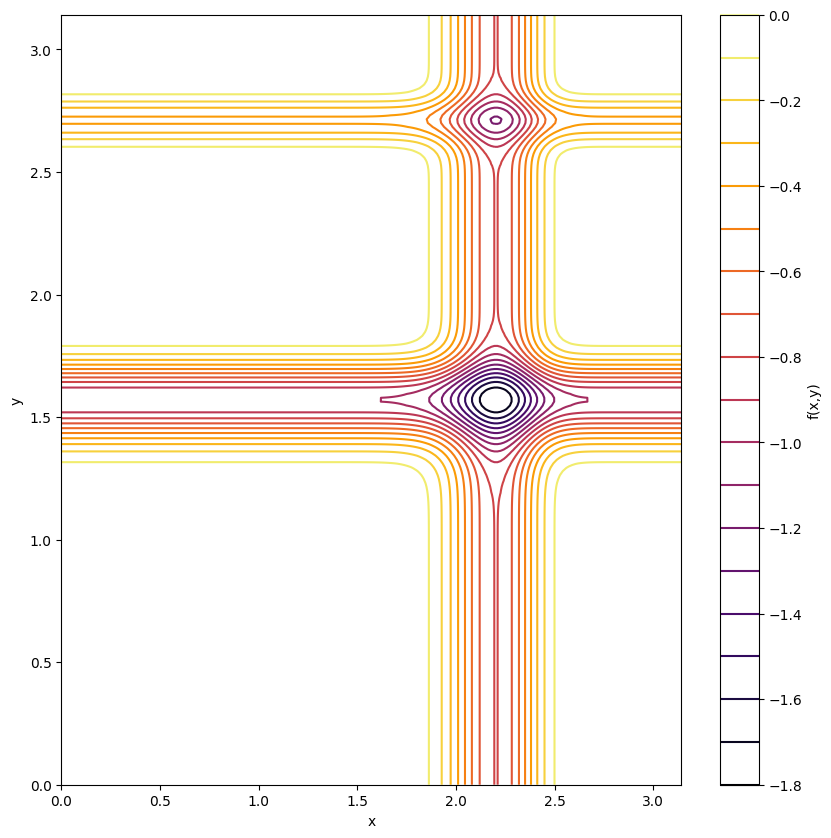

In [14]:
# Create a mesh grid for the plot
x = np.linspace(0, math.pi, 200)
y = np.linspace(0, math.pi, 200)
X, Y = np.meshgrid(x, y)

# Calculate Michalewicz function values for each point in the mesh grid
Z = np.array([[michalewicz_function([x, y]) for x, y in zip(x_row, y_row)] for x_row, y_row in zip(X, Y)])

# Plot the 3D surface
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='inferno', alpha=0.8)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x,y)')
plt.show()

# Plot the 2D contour
fig, ax = plt.subplots(figsize=(10, 10))
contour = ax.contour(X, Y, Z, cmap='inferno', levels=20)
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.colorbar(contour, label='f(x,y)')
plt.show()

## Solving using PSO

#### Create Particle class

In [15]:
class Particle:
    def __init__(self, position, velocity, pbest_position, pbest_value):
        self.position = position
        self.velocity = velocity
        self.pbest_position = pbest_position
        self.pbest_value = pbest_value

#### Define fitness finction

In [16]:
def fitness_function(position):
    return michalewicz_function(position)

#### Define velocity update function 

$v_{k+1}=\omega \times v_k+c1 \times rand1 (pbest_k-x_k)+c2 \times rand2_k (gbest_k-x_k)$

In [17]:
def update_velocity(particle, gbest_position, options):    
    w = options['w']
    c1 = options['c1']
    c2 = options['c2']
    inertia = w * particle.velocity
    cognitive = c1 * np.random.rand() * (particle.pbest_position - particle.position)
    social = c2 * np.random.rand() * (gbest_position - particle.position)
    new_velocity = inertia + cognitive + social
    return new_velocity

#### Define PSO solver

In [18]:
def pso(swarm_size, iterations, bounds, options, topology):
    # Initialize swarm
    swarm = []
    for i in range(swarm_size):
        position = np.array([np.random.uniform(low=low, high=high) for low, high in bounds])
        velocity = np.array([np.random.uniform(low=-abs(high-low), high=abs(high-low)) for low, high in bounds])
        pbest_position = position
        pbest_value = fitness_function(position)
        particle = Particle(position, velocity, pbest_position, pbest_value)
        swarm.append(particle)

    gbest_position = swarm[np.argmin([particle.pbest_value for particle in swarm])].pbest_position
    gbest_value = np.min([particle.pbest_value for particle in swarm])

    for _ in range(iterations):
        for i, particle in enumerate(swarm):
            # Update velocity and position
            particle.velocity = update_velocity(particle, gbest_position, options)
            particle.position += particle.velocity

            # Apply bounds
            particle.position = np.clip(particle.position, [low for low, high in bounds], [high for low, high in bounds])

            # Update personal best (pbest)
            current_value = fitness_function(particle.position)
            if current_value < particle.pbest_value:
                particle.pbest_position = particle.position
                particle.pbest_value = current_value

            # Update global best (gbest) based on the selected topology
            # Assuming minimization problem
            if topology == 'star':
                if current_value < gbest_value:
                    gbest_position = particle.position
                    gbest_value = current_value
            elif topology == 'ring':
                neighbors = [swarm[(i - 1) % swarm_size], swarm[(i + 1) % swarm_size]]
                lbest_position = min(neighbors, key=lambda p: p.pbest_value).pbest_position
                particle.velocity = update_velocity(particle, lbest_position, options)
            elif topology == 'von_neumann':
                grid_size = int(np.ceil(np.sqrt(swarm_size)))
                row, col = i // grid_size, i % grid_size
                neighbors_indices = [
                    row * grid_size + ((col - 1) % grid_size),
                    row * grid_size + ((col + 1) % grid_size),
                    ((row - 1) % grid_size) * grid_size + col,
                    ((row + 1) % grid_size) * grid_size + col,
                ]
                # Ensure neighbors_indices do not exceed the swarm_size
                neighbors_indices = [idx for idx in neighbors_indices if idx < swarm_size]
                neighbors = [swarm[idx] for idx in neighbors_indices]
                lbest_position = min(neighbors, key=lambda p: p.pbest_value).pbest_position
                particle.velocity = update_velocity(particle, lbest_position, options)
            elif topology == 'wheel':
                if i == 0:
                    hub_best_position = min(swarm[1:], key=lambda p: p.pbest_value).pbest_position
                    particle.velocity = update_velocity(particle, hub_best_position, options)
                else:
                    particle.velocity = update_velocity(particle, swarm[0].pbest_position, options)

            particle.position += particle.velocity

    return gbest_position, gbest_value


#### Set up problem and algorithm parameters

In [19]:
# PSO Parameters
swarm_size = 50
iterations = 1000
topology='star' # Select topology from ['star', 'ring', 'von_neumann', 'wheel']
options = {'w': 0.9, 'c1': 0.5, 'c2': 0.3}

# Dimension and domain of Michalewicz function (0, pi) for each variable
dimension = 2
bounds = [(0, math.pi)] * dimension

#### Run the PSO algorithm for each topology and print the results

In [20]:
print(f"Topology: {topology}")
best_position, best_value = pso(swarm_size, iterations, bounds, options, topology)
print(f"Best position: {np.round(best_position,3)}")
print(f"Best value: {np.round(best_value,4)}")
print()

Topology: star
Best position: [2.204 1.572]
Best value: -1.8013



## Solving using PySwarms PSO solver

In [21]:
# def michalewicz function to be used in the PSO PySwarms
def michalewicz(x):
    m=10
    n = x.shape[1]
    j = np.arange(1, n + 1)
    s = np.sin(x) * np.power(np.sin((j * x**2) / np.pi), 2 * m)
    return -np.sum(s, axis=1)

In [22]:
# Import PSO solver from pyswarms
import pyswarms as ps

# Dimension of Michalewicz function
dimension = 2

# Create a bounds for the search space
bounds = (np.zeros(dimension), np.pi * np.ones(dimension))

# Set up the optimizer
options = {'w': 0.9, 'c1': 0.5, 'c2': 0.3}

# Create an instance of the optimizer
optimizer = ps.single.GlobalBestPSO(n_particles=100, dimensions=dimension, options=options, bounds=bounds)

# Optimize the Michalewicz function
cost, pos = optimizer.optimize(michalewicz, iters=1000)

print(f"Optimal position: {np.round(pos,3)}")
print(f"Optimal cost: {np.round(cost,4)}")
print()

2023-04-23 21:02:25,239 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'w': 0.9, 'c1': 0.5, 'c2': 0.3}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.8
2023-04-23 21:02:28,022 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.8013034100985537, best pos: [2.20290552 1.57079632]


Optimal position: [2.203 1.571]
Optimal cost: -1.8013



#### Plot the cost history

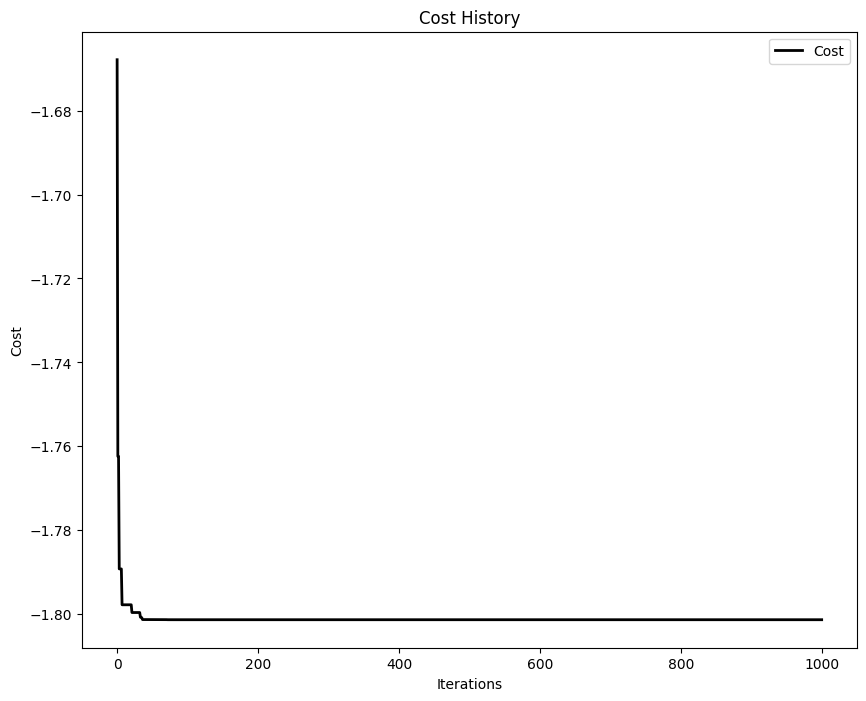

In [23]:
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)
plot_cost_history(cost_history=optimizer.cost_history)
plt.show()

## Visualize the results

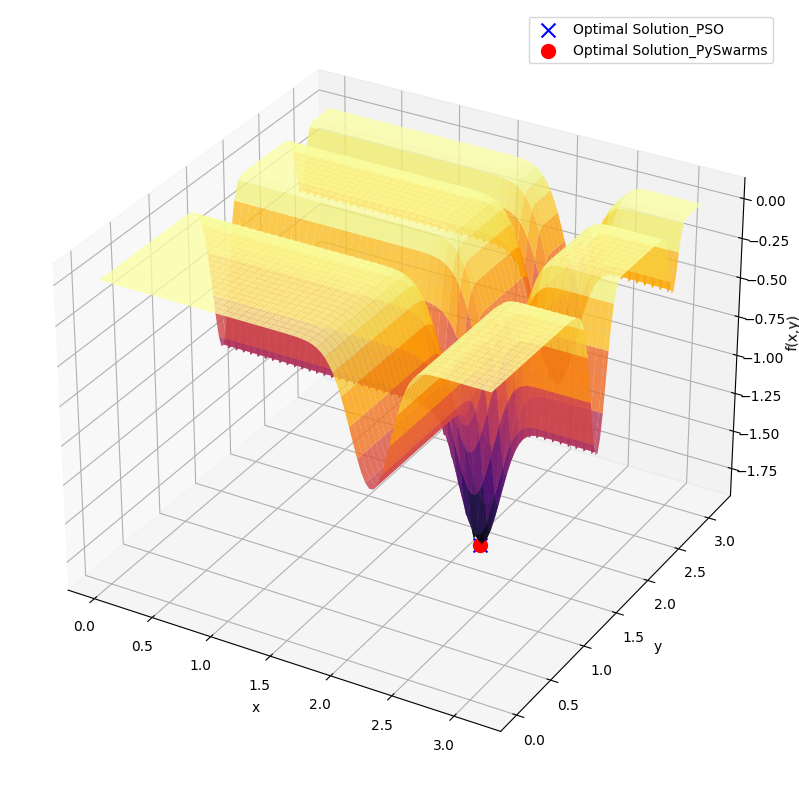

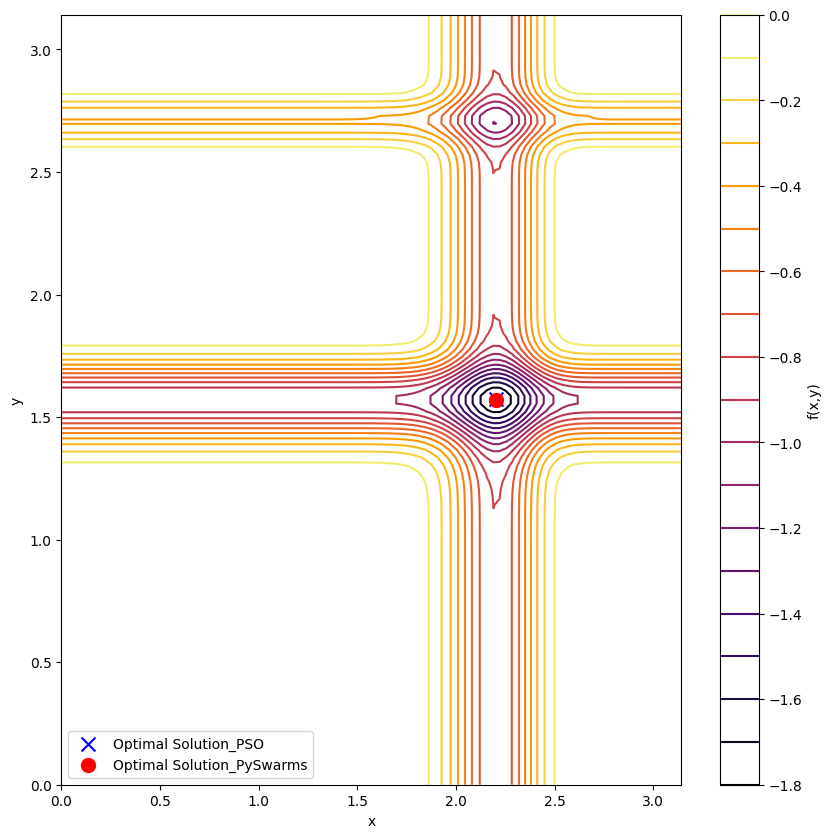

In [24]:
# Set up a meshgrid for plotting
x_range = np.linspace(0, np.pi, 100)
y_range = np.linspace(0, np.pi, 100)
x, y = np.meshgrid(x_range, y_range)

# Evaluate the Michalewicz function on the meshgrid
xy_pairs = np.vstack((x.flatten(), y.flatten())).T
z = michalewicz(xy_pairs)
z = z.reshape(x.shape)

# Plot the 3D surface
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z, cmap='inferno', alpha=0.8)
ax.scatter(best_position[0], best_position[1], best_value, c='b', marker='x', s=100, label='Optimal Solution_PSO')
ax.scatter(pos[0], pos[1], cost, c='r', marker='o', s=100, label='Optimal Solution_PySwarms')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x,y)')
ax.legend()
plt.show()
# plt.savefig('CH09_F07_3d_michalewicz.png', dpi=300)

# Plot the 2D contour
fig, ax = plt.subplots(figsize=(10, 10))
contour = ax.contour(x, y, z, cmap='inferno', levels=20)
plt.scatter(best_position[0], best_position[1], c='b', marker='x', s=100, label='Optimal Solution_PSO')
plt.scatter(pos[0], pos[1], c='r', marker='o', s=100, label='Optimal Solution_PySwarms')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.colorbar(contour, label='f(x,y)')
ax.legend(loc='lower left')
plt.show()
# plt.savefig('CH09_F08_2d_michalewicz.png', dpi=300)